In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Chapter 6: Monte Carlo simulations in finance

Monte Carlo simulation es una clase de algoritmos que usan sampleo aleatorio repetido para resolver cualquier problema que tenga una interpretación probabilística. 

En finanzas, pueden usarse para estimar integrales. 

Son capaces de producir multiples caminos /escenarios,durante un perido de tiempo. 

El horizonte es dividido en un número específico de time steps y el proceso de hacerlo es llamado discretización. 

El goal es aproximar tiempo contínuo, ya que el pricing de instumentos financieros ocurre de tiempo contínuo.

Los resultados de todas estas simulaciones pueden ser usados para calcular metricas como el % de un evento ocurre, el avg value de un instrumentos en el último time step. 

El problema histórico es que requería mucho poder de computación, 



## Simulating stock price dynamics using Geometric Brownian Motion

Debido a la impredicibildiad de los mercados, simular stock prices juega un role importante en la valoración de  muchos derivados, como opciones. Debido a esto, muchas simulaciones recaen en SDE (stochastic differential equations)

Un proces stocástico sigue el llamado Geometric Brownian Motion cuando cumple la siguiente SDE:
    dS=muSdt + sigmnaSdWt
    
    
    Obtenemos un camino browniano tomando la suma cumulativa de incrementos brownianos

### How to do it...

1. Import libraries:

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

2. Define parameters for downloading data:

In [4]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

3. Download data from Yahoo Finance:

In [6]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 145 rows of data.


4. Calculate daily returns:

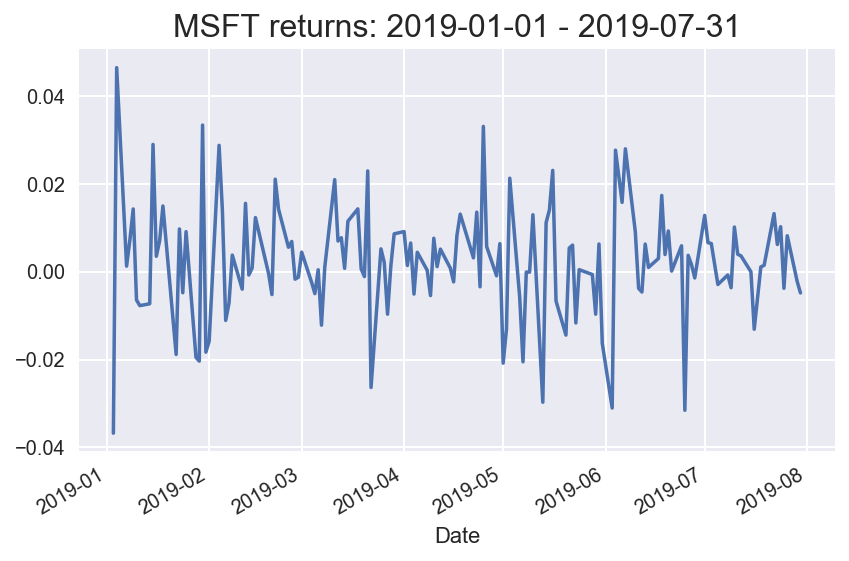

Average return: 0.24%


In [7]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
plt.savefig('images/ch6_im1.png')
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

5. Split data into the training and test sets:

In [8]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

6. Specify the parameters of the simulation:

In [9]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

7. Define the function used for simulations:

In [10]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

8. Run the simulations:

In [11]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

9. Plot simulation results:

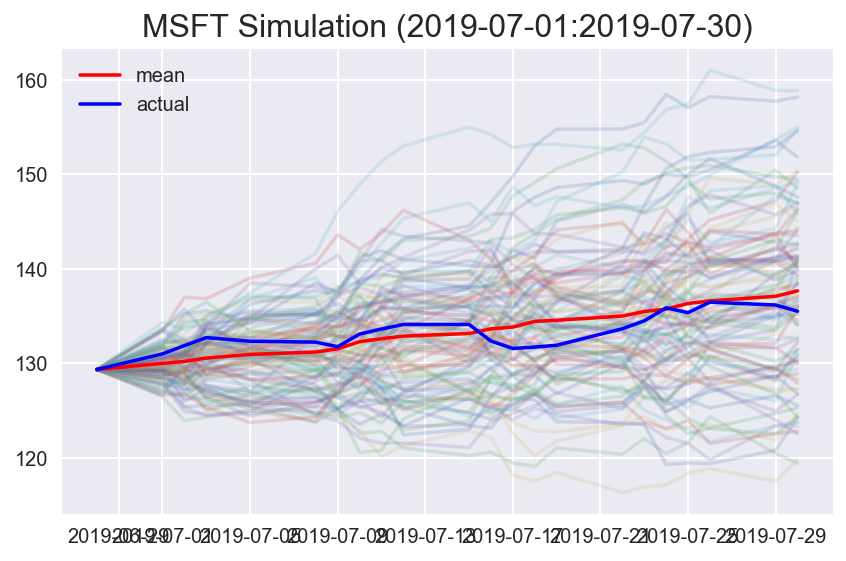

In [12]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.savefig('images/ch6_im2.png')
plt.show()

### There's more 

In [13]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

137 µs ± 900 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [15]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

71.6 µs ± 307 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

56.5 µs ± 268 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Pricing European Options using Simulations 

### How to do it...

1. Import the libraries:

In [17]:
import numpy as np
from scipy.stats import norm
from chapter_6_utils import simulate_gbm

2. Define the parameters for the valuation:

In [18]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the function using the analytical solution:

In [19]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

4. Valuate the call option using the specified parameters:

In [20]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

5. Simulate the stock path using GBM:

In [21]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

6. Calculate the option premium:

In [22]:
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.756178586245806

### There's more

In [23]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

In [24]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type='call', random_seed=42):
    '''
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Allowable: ['call', 'put']
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    '''
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type!')
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

In [25]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type='put')

16.948225203893127

## Pricing American Options with Least Squares Monte Carlo

### How to do it...

1. Import the libraries:

In [26]:
import numpy as np
from chapter_6_utils import (simulate_gbm, 
                             black_scholes_analytical, 
                             lsmc_american_option)

2. Define the parameters:

In [27]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5 

3. Simulate the stock prices using GBM:

In [28]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

4. Calculate the payoff matrix:

In [29]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

5. Define the value matrix and fill in the last column (time T):

In [5]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

6. Iteratively calculate the continuation value and the value vector in the given time:

In [6]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

7. Calculate the option premium:

In [9]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.465


8. Calculate the premium of a European put with the same parameters:

In [10]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type='put')

3.84430779159684

9. As an extra check, calculate the prices of the American and European call options:

In [11]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type='call', 
                                           poly_degree=POLY_DEGREE)
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price (using {N_SIMS} simulations) is {american_call_price:.3f}")

The price of the European call is 2.174, and the American call's price (using 100000 simulations) is 2.097


## Pricing American Options using Quantlib

### How to do it...

0: Defining parameters:

In [12]:
S_0 = 36
r = 0.06
sigma = 0.2
K = 40
OPTION_TYPE = 'put'
POLY_DEGREE = 5 
R_SEED = 42
N_SIMS = 10 ** 5 
N = 50 

1. Import the library:

In [13]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [24]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

3. Specify the valuation date and the expiry date of the option:

In [25]:
valuation_date = ql.Date(1, 1, 2018)
expiry_date =  ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = valuation_date

4. Define the option type (call/put), type of exercise and the payoff:

In [26]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [17]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [18]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [19]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for the American options:

In [20]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=R_SEED, 
                             requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [21]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

10. Calculate the option premium:

In [22]:
option_premium_ql = option.NPV()

In [23]:
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.470


### There's more

In [33]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -1.25


## Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import libraries:

In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [43]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this exercise:

In [44]:
RISKY_ASSETS = ['GOOG', 'FB']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [45]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 downloaded
Downloaded 250 rows of data.


In [46]:
df.head()

Adj Close            Close             High              Low  \
                  FB     GOOG      FB     GOOG      FB     GOOG      FB   
Date                                                                      
2018-01-02    181.42  1065.00  181.42  1065.00  181.58  1066.94  177.55   
2018-01-03    184.67  1082.48  184.67  1082.48  184.78  1086.29  181.33   
2018-01-04    184.33  1086.40  184.33  1086.40  186.21  1093.57  184.10   
2018-01-05    186.85  1102.23  186.85  1102.23  186.90  1104.25  184.93   
2018-01-08    188.28  1106.94  188.28  1106.94  188.90  1111.27  186.33   

                       Open             Volume           
               GOOG      FB     GOOG        FB     GOOG  
Date                                                     
2018-01-02  1045.23  177.68  1048.34  18151900  1237600  
2018-01-03  1063.21  181.88  1064.31  16886600  1430200  
2018-01-04  1084.00  184.90  1088.00  13880900  1004600  
2018-01-05  1092.00  185.59  1094.00  13574500  1279100  
2018-01-08  1101.62  187.20  1102.23  17994700  1047600

4. Calculate daily returns:

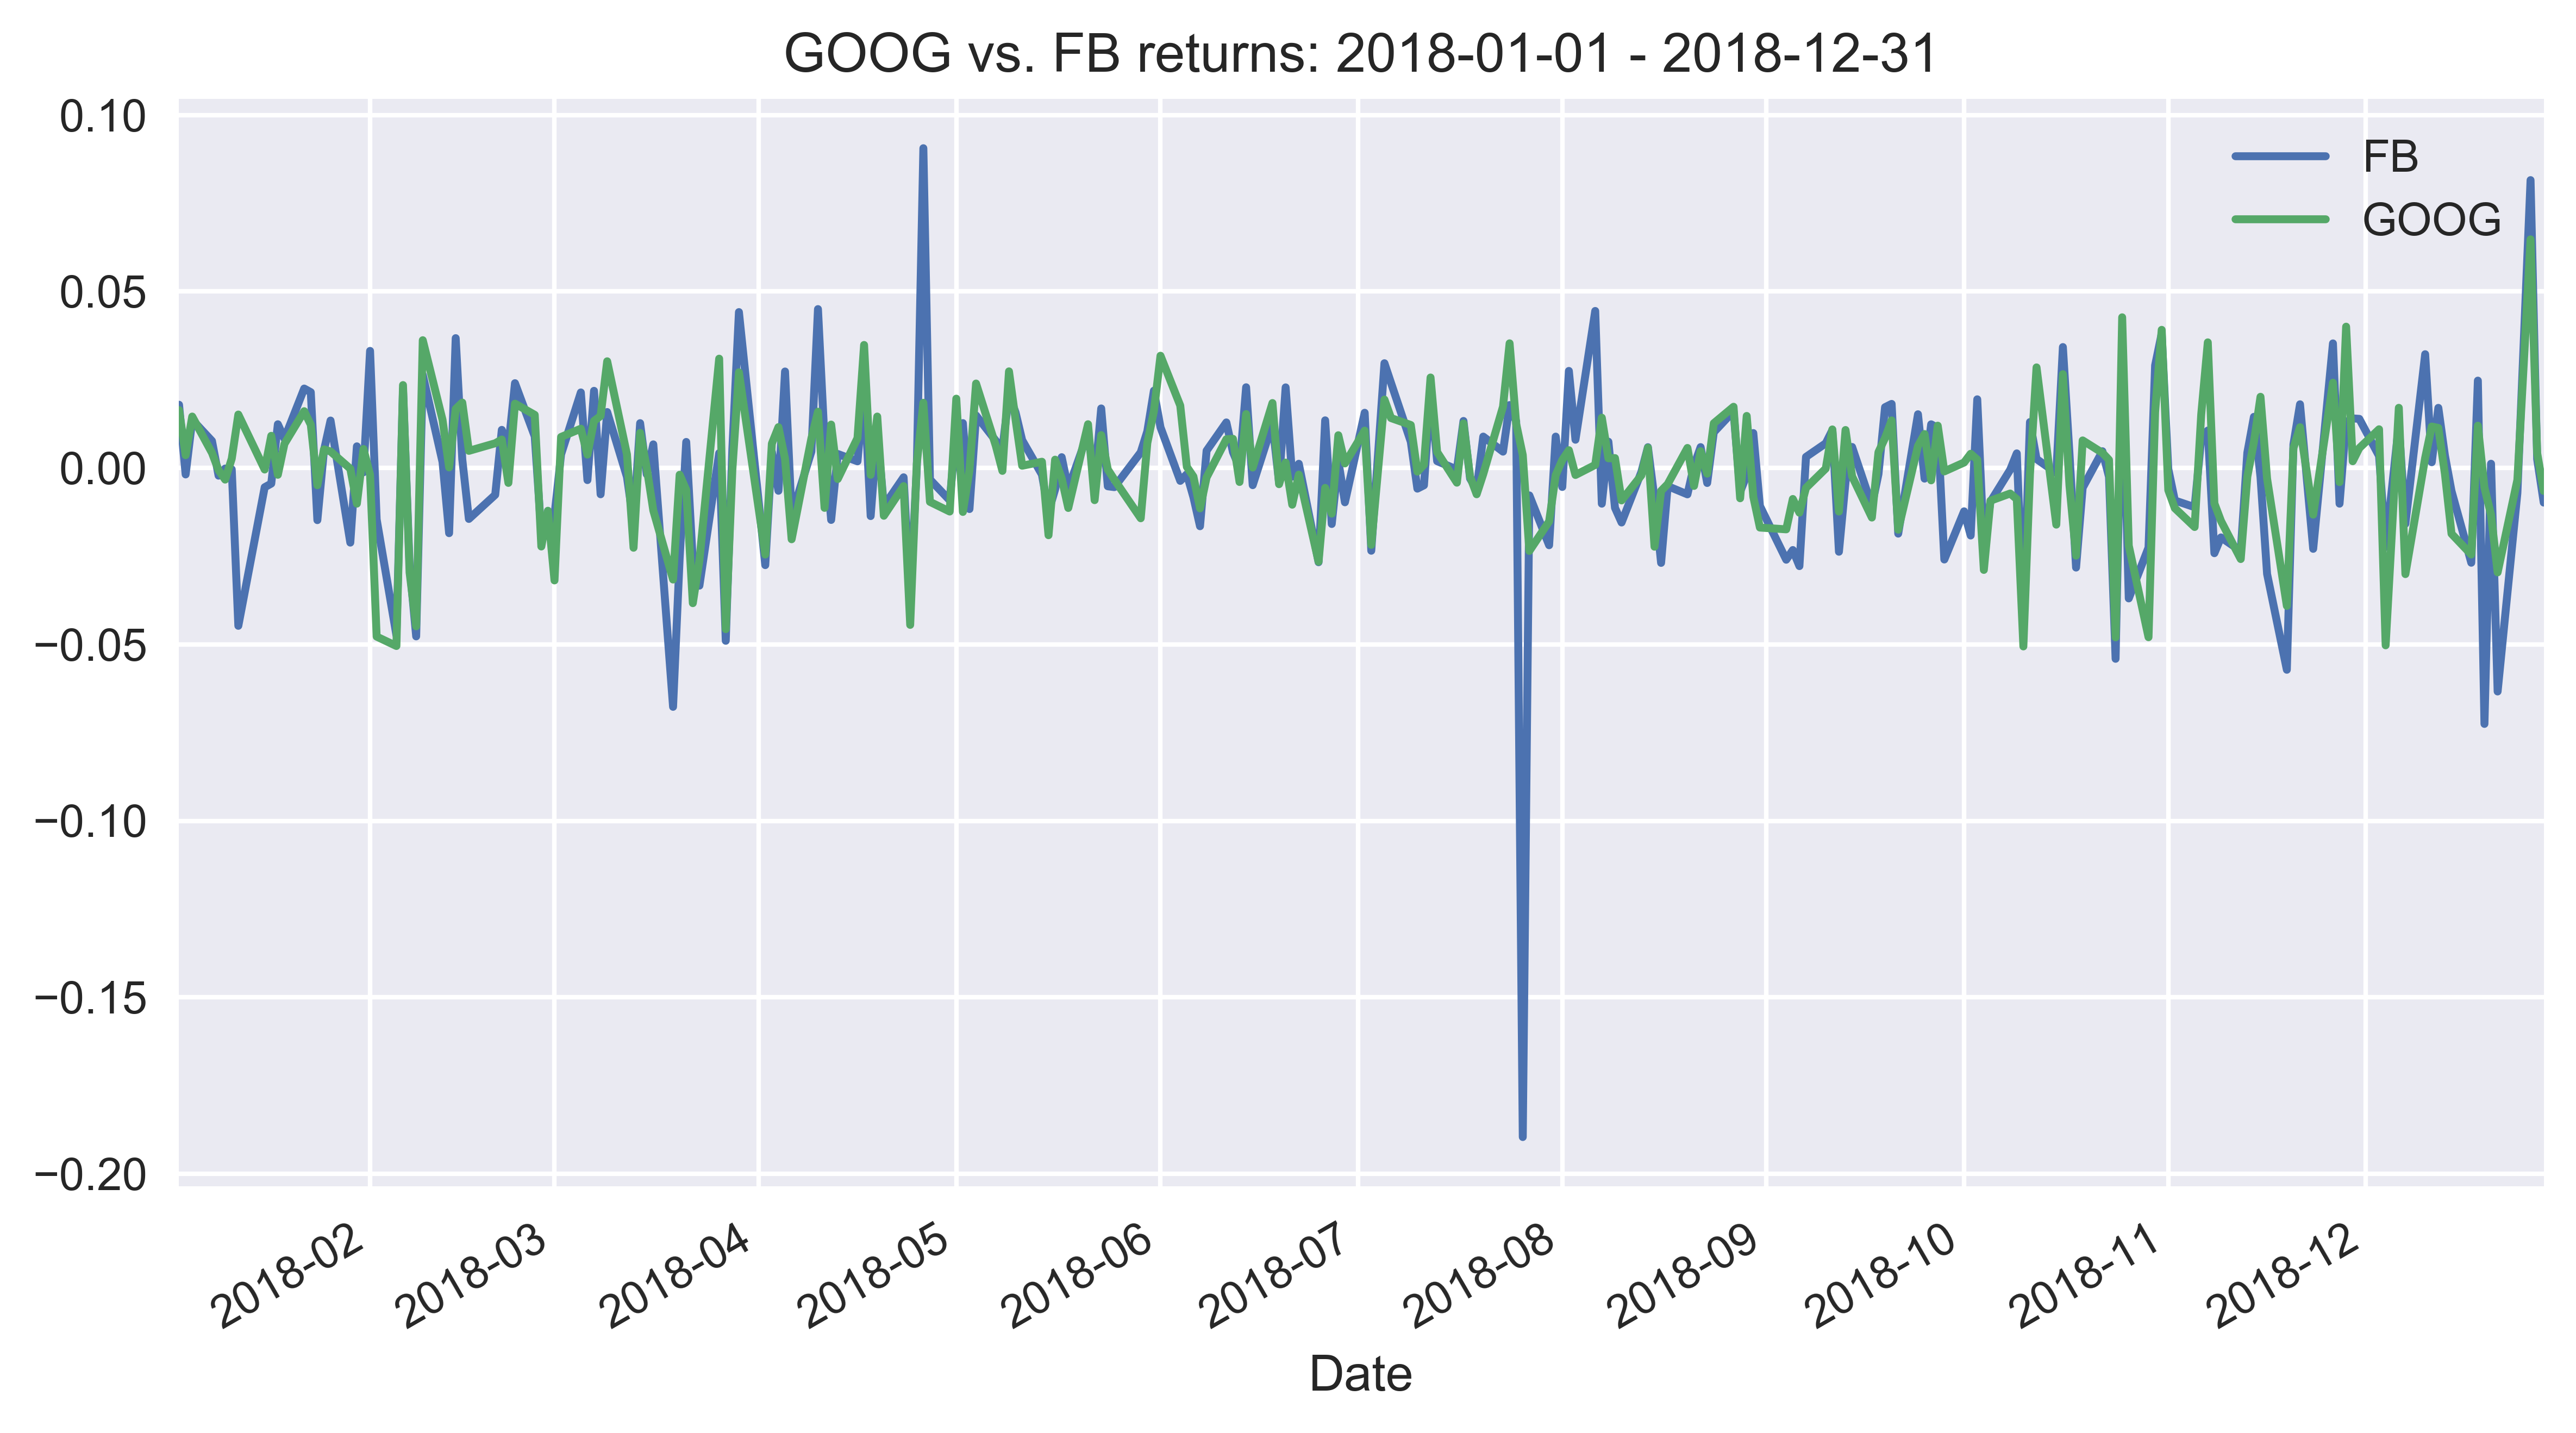

Correlation between returns: 0.62


In [47]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
plt.savefig('images/ch6_im3.png')
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [48]:
cov_mat = returns.cov()
cov_mat

,FB,GOOG
FB,0.000575,0.000265
GOOG,0.000265,0.000315


6. Perform the Cholesky decomposition of the covariance matrix:

In [49]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02397822, 0.        ],
       [0.01105642, 0.01389753]])

7. Draw correlated random numbers from Standard Normal distribution:

In [50]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [51]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

In [52]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [53]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [54]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 8.24$
1-day VaR with 99.9% confidence: 7.14$
1-day VaR with 99.0% confidence: 5.78$


12. Present the results on a graph:

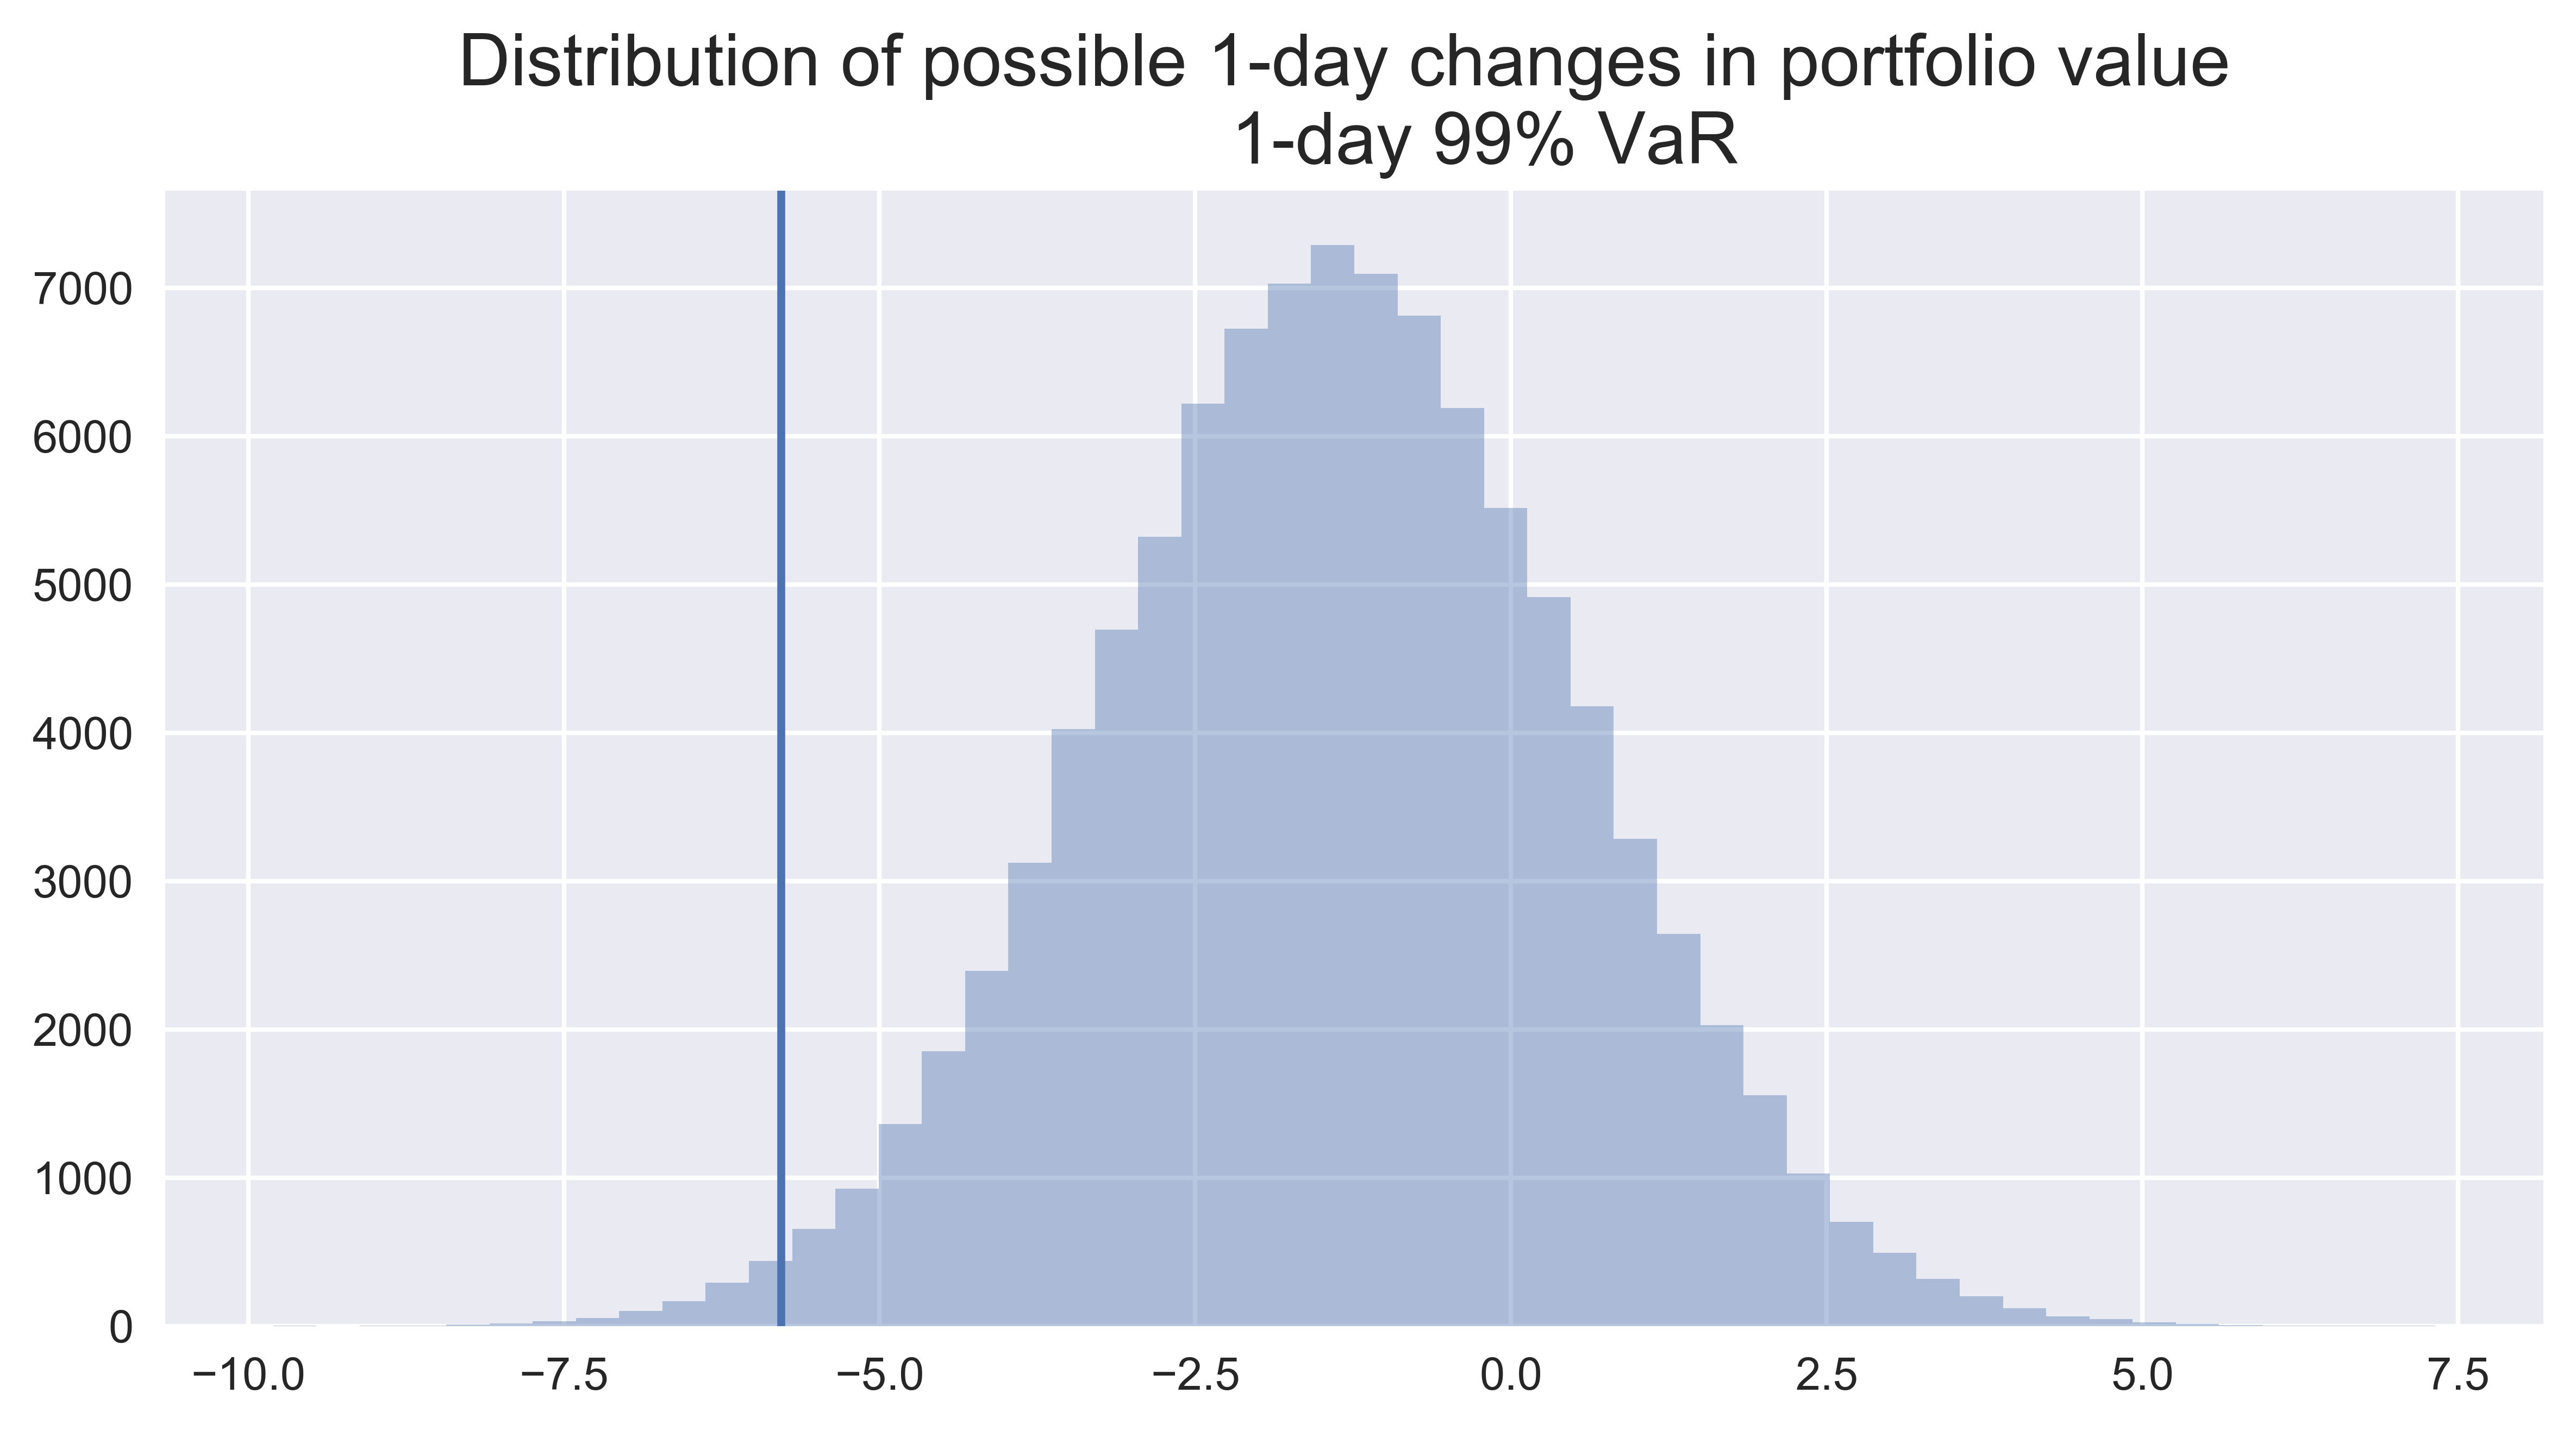

In [55]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()
plt.savefig('images/ch6_im4.png')
plt.show()

### There's more

In [56]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 4.48$, and the accompanying Expected Shortfall is 5.27$.
